<a href="https://colab.research.google.com/github/preethammmm/Complaint-classification/blob/main/classification_complaints.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import json
import pandas as pd

# 1. Data Loading
def load_data(filepath):
    """Loads the JSON data into a Pandas DataFrame."""
    with open(filepath, 'r') as file:
        data = json.load(file)
    df = pd.json_normalize(data)
    return df

filepath = "/content/complaints-2021-05-14_08_16.json"  # Replace with the actual path to file
df = load_data(filepath)

# 2. Initial Data Exploration
def explore_data(df):
    """Performs initial data exploration."""

    print("--- DataFrame Info ---")
    df.info()  # Get column names, data types, and non-null counts

    print("\n--- Missing Values ---")
    print(df.isnull().sum())  # Count missing values per column

    print("\n--- Class Distribution ---")
    print(df['_source.product'].value_counts())  # Check the distribution of complaint categories

    print("\n--- Sample Complaints ---")
    print(df['_source.complaint_what_happened'].head().to_string())  # Show a few raw complaint texts


explore_data(df)

--- DataFrame Info ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 78313 entries, 0 to 78312
Data columns (total 22 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   _index                             78313 non-null  object 
 1   _type                              78313 non-null  object 
 2   _id                                78313 non-null  object 
 3   _score                             78313 non-null  float64
 4   _source.tags                       10900 non-null  object 
 5   _source.zip_code                   71556 non-null  object 
 6   _source.complaint_id               78313 non-null  object 
 7   _source.issue                      78313 non-null  object 
 8   _source.date_received              78313 non-null  object 
 9   _source.state                      76322 non-null  object 
 10  _source.consumer_disputed          78313 non-null  object 
 11  _source.product                

In [5]:
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt_tab')
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# Initialize lemmatizer and stop words (do this once outside the function for efficiency)
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

def preprocess_text(text):
    """
    Preprocesses text by performing several cleaning and normalization steps.

    Args:
        text (str): The text to preprocess.

    Returns:
        str: The preprocessed text.
    """

    # 0. Handle Empty Strings (NEW)
    if not text or text.isspace():
        return "empty"  # Or any other placeholder you prefer

    # 1. Lowercase
    text = text.lower()

    # 2. Handle Contractions
    text = re.sub(r"can't", "cannot", text)
    text = re.sub(r"won't", "will not", text)
    text = re.sub(r"n't", " not", text)
    text = re.sub(r"'s", " is", text)
    text = re.sub(r"'m", " am", text)
    text = re.sub(r"'ve", " have", text)
    text = re.sub(r"'re", " are", text)
    text = re.sub(r"'d", " would", text)

    # 3. Remove Special Characters and Punctuation
    text = re.sub(r"[^a-zA-Z\s]", "", text)

    # 4. Tokenize
    tokens = nltk.word_tokenize(text)

    # 5. Remove Stop Words
    tokens = [token for token in tokens if token not in stop_words]

    # 6. Lemmatize
    tokens = [lemmatizer.lemmatize(token) for token in tokens]

    # 7. Join Back into String
    text = " ".join(tokens)

    return text

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


In [6]:
df['processed_complaint'] = df['_source.complaint_what_happened'].apply(preprocess_text)
print(df['processed_complaint'].head().to_string())

0                                                empty
1    good morning name xxxx xxxx appreciate could h...
2    upgraded xxxx xxxx card xxxx told agent upgrad...
3                                                empty
4                                                empty


In [7]:
from sklearn.feature_extraction.text import TfidfVectorizer

# 1. TF-IDF Vectorization
def create_tfidf_features(df, max_features=10000):
    """
    Creating TF-IDF features from the processed complaint text.

    Args:
        df (pd.DataFrame): DataFrame containing the processed complaint text.
        max_features (int, optional): Maximum number of features to extract. Defaults to 10000.

    Returns:
        tuple: TF-IDF matrix and the fitted TfidfVectorizer.
    """

    tfidf_vectorizer = TfidfVectorizer(max_features=max_features, stop_words='english')  # You can adjust max_features
    tfidf_matrix = tfidf_vectorizer.fit_transform(df['processed_complaint'])
    return tfidf_matrix, tfidf_vectorizer

tfidf_matrix, tfidf_vectorizer = create_tfidf_features(df)

# 2. Display Feature Information
def display_tfidf_info(tfidf_matrix, tfidf_vectorizer):
    """
    Displays information about the TF-IDF feature matrix.
    """
    print("\n--- TF-IDF Feature Info ---")
    print(f"Shape of TF-IDF matrix: {tfidf_matrix.shape}")  # (Number of complaints, Number of features)
    print(f"Number of unique tokens: {len(tfidf_vectorizer.vocabulary_)}")

display_tfidf_info(tfidf_matrix, tfidf_vectorizer)


--- TF-IDF Feature Info ---
Shape of TF-IDF matrix: (78313, 10000)
Number of unique tokens: 10000



--- Logistic Regression ---


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


                                                                              precision    recall  f1-score   support

                                                     Bank account or service       0.26      0.00      0.01      1963
                                                 Checking or savings account       0.66      0.27      0.39      2430
                                                               Consumer Loan       0.29      0.02      0.04       206
                                                                 Credit card       0.61      0.02      0.04      2075
                                                 Credit card or prepaid card       0.65      0.38      0.48      2160
                                                            Credit reporting       0.00      0.00      0.00        38
Credit reporting, credit repair services, or other personal consumer reports       0.56      0.34      0.42       862
                                                       

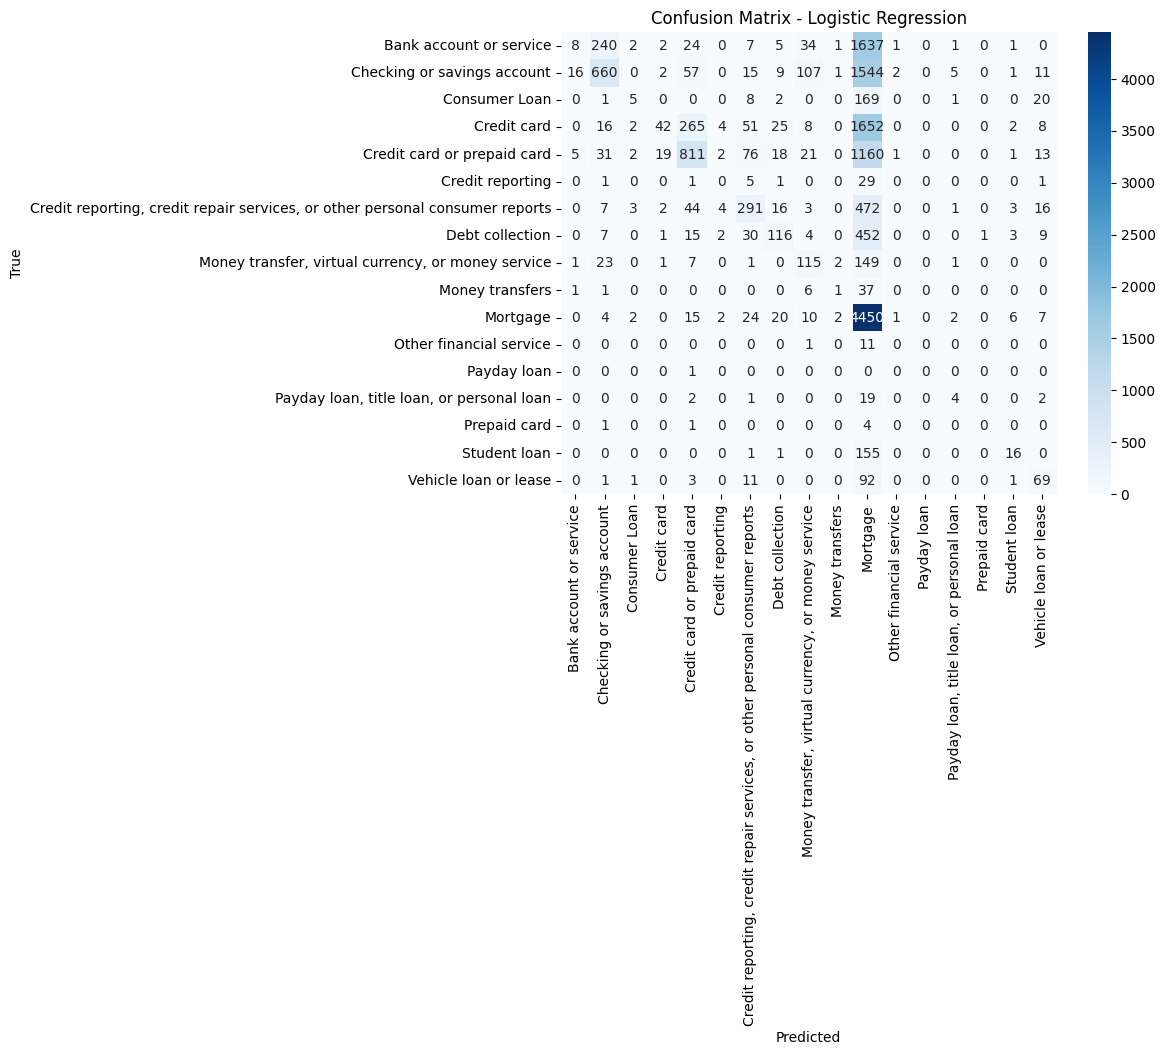


--- Naive Bayes ---


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


                                                                              precision    recall  f1-score   support

                                                     Bank account or service       0.00      0.00      0.00      1963
                                                 Checking or savings account       0.57      0.32      0.41      2430
                                                               Consumer Loan       0.00      0.00      0.00       206
                                                                 Credit card       0.46      0.00      0.01      2075
                                                 Credit card or prepaid card       0.56      0.40      0.47      2160
                                                            Credit reporting       0.00      0.00      0.00        38
Credit reporting, credit repair services, or other personal consumer reports       0.70      0.15      0.25       862
                                                       

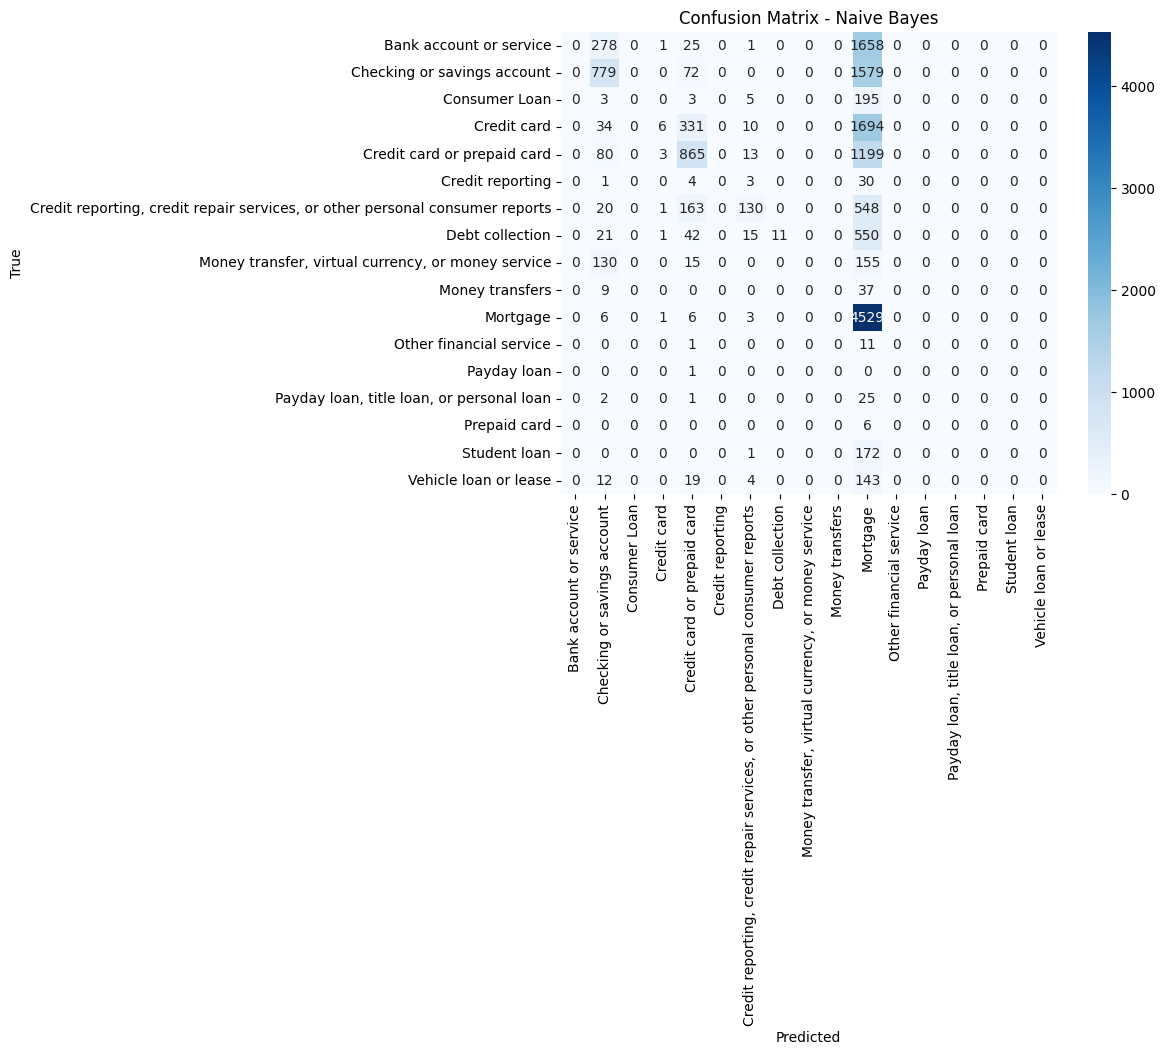

In [8]:
from sklearn.model_selection import train_test_split, cross_val_score, KFold, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# 1. Split Data into Training and Testing Sets
def split_data(tfidf_matrix, df, test_size=0.2, random_state=42):
    """
    Splits the data into training and testing sets.

    Args:
        tfidf_matrix (sparse matrix): TF-IDF matrix.
        df (pd.DataFrame): DataFrame containing the target variable.
        test_size (float, optional): Proportion of data to use for testing. Defaults to 0.2.
        random_state (int, optional): Random seed for reproducibility. Defaults to 42.

    Returns:
        tuple: Training and testing sets (X_train, X_test, y_train, y_test).
    """

    X = tfidf_matrix
    y = df['_source.product']  # Target variable (complaint category)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state, stratify=y)
    return X_train, X_test, y_train, y_test

X_train, X_test, y_train, y_test = split_data(tfidf_matrix, df)


# 2. Train and Evaluate Models (Logistic Regression - Modified)
def train_evaluate_model(X_train, X_test, y_train, y_test, model, model_name, cv=5):
    """
    Trains and evaluates a classification model.

    Args:
        X_train (sparse matrix): Training features.
        X_test (sparse matrix): Testing features.
        y_train (pd.Series): Training labels.
        y_test (pd.Series): Testing labels.
        model (estimator): The classification model to train.
        model_name (str): Name of the model.
        cv (int, optional): Number of cross-validation folds. Defaults to 5.

    Returns:
        None: Prints evaluation metrics.
    """

    print(f"\n--- {model_name} ---")

    # Train the model
    model.fit(X_train, y_train)

    # Make predictions
    y_pred = model.predict(X_test)

    # Evaluate the model
    print(classification_report(y_test, y_pred))  # Detailed classification report

    # Cross-validation (for a more robust estimate of performance)
    cv_scores = cross_val_score(model, X_train, y_train, cv=cv, scoring='accuracy')
    print(f"Cross-validation accuracy: {np.mean(cv_scores):.4f} (+/- {np.std(cv_scores):.4f})")

    # Confusion Matrix (Visualize errors)
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=model.classes_, yticklabels=model.classes_)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(f'Confusion Matrix - {model_name}')
    plt.show()


# Initialize and train models
logistic_regression = LogisticRegression(random_state=42, solver='liblinear', class_weight='balanced')  # Added class_weight
naive_bayes = MultinomialNB()

train_evaluate_model(X_train, X_test, y_train, y_test, logistic_regression, 'Logistic Regression')
train_evaluate_model(X_train, X_test, y_train, y_test, naive_bayes, 'Naive Bayes')

In [9]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

# Define the parameter grid for Logistic Regression
param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],  # Regularization strength
    'solver': ['liblinear', 'lbfgs'],       # Algorithm to use for optimization
    'max_iter': [100, 200]                 # Maximum number of iterations
}

# Initialize Logistic Regression with class_weight='balanced'
log_reg = LogisticRegression(class_weight='balanced', random_state=42)

# Initialize GridSearchCV
grid_search = GridSearchCV(log_reg, param_grid, cv=5, scoring='f1_weighted', verbose=2, n_jobs=-1)

# Fit GridSearchCV to the training data
grid_search.fit(X_train, y_train)

# Print the best parameters and the best score
print("Best Parameters:", grid_search.best_params_)
print("Best Cross-Validation F1 Score:", grid_search.best_score_)

# Get the best model from GridSearchCV
best_log_reg = grid_search.best_estimator_

# Evaluate the best model on the test set
y_pred = best_log_reg.predict(X_test)
print("\nClassification Report for Best Logistic Regression Model:\n", classification_report(y_test, y_pred))

Fitting 5 folds for each of 24 candidates, totalling 120 fits
Best Parameters: {'C': 10, 'max_iter': 100, 'solver': 'liblinear'}
Best Cross-Validation F1 Score: 0.34167400319930874


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



Classification Report for Best Logistic Regression Model:
                                                                               precision    recall  f1-score   support

                                                     Bank account or service       0.40      0.04      0.07      1963
                                                 Checking or savings account       0.69      0.26      0.38      2430
                                                               Consumer Loan       0.19      0.03      0.05       206
                                                                 Credit card       0.51      0.05      0.10      2075
                                                 Credit card or prepaid card       0.67      0.35      0.46      2160
                                                            Credit reporting       0.00      0.00      0.00        38
Credit reporting, credit repair services, or other personal consumer reports       0.56      0.33      0.42      

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [10]:
!pip install imblearn

In [11]:
import numpy as np
import pandas as pd  # Make sure pandas is imported

# Count the number of samples per class in the training data
# Convert y_train to numerical labels using factorize
y_train_numeric, unique_classes = pd.factorize(y_train)  # Modify this line
class_counts = np.bincount(y_train_numeric)
classes = unique_classes

print("Class Distribution in Training Data:")
for i in range(len(classes)):
    print(f"Class {classes[i]}: {class_counts[i]} samples")

# Find the smallest number of samples among minority classes (excluding classes with 0 samples)
minority_class_counts = class_counts[class_counts > 0]
min_samples = np.min(minority_class_counts)

print(f"\nSmallest number of samples in any class: {min_samples}")

Class Distribution in Training Data:
Class Mortgage: 18180 samples
Class Credit reporting, credit repair services, or other personal consumer reports: 3448 samples
Class Credit card or prepaid card: 8637 samples
Class Checking or savings account: 9717 samples
Class Credit card: 8298 samples
Class Bank account or service: 7853 samples
Class Debt collection: 2561 samples
Class Student loan: 693 samples
Class Vehicle loan or lease: 714 samples
Class Money transfer, virtual currency, or money service: 1200 samples
Class Money transfers: 182 samples
Class Consumer Loan: 823 samples
Class Credit reporting: 154 samples
Class Payday loan, title loan, or personal loan: 111 samples
Class Other financial service: 48 samples
Class Prepaid card: 26 samples
Class Payday loan: 5 samples

Smallest number of samples in any class: 5


In [13]:
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

# Initialize SMOTE for oversampling
smote = SMOTE(random_state=42, k_neighbors=3)  # Adjust k_neighbors if necessary

# Apply SMOTE to the training data only
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Initialize Logistic Regression with class_weight='balanced'
log_reg_smote = LogisticRegression(class_weight='balanced', random_state=42, C=10, solver='liblinear', max_iter=100)  # Using best params from grid search (if available)

# Train Logistic Regression on the resampled training data
log_reg_smote.fit(X_train_resampled, y_train_resampled)

# Make predictions on the test set
y_pred_smote = log_reg_smote.predict(X_test)

# Print the Classification Report
print("Classification Report for Logistic Regression with SMOTE:\n", classification_report(y_test, y_pred_smote))

Classification Report for Logistic Regression with SMOTE:
                                                                               precision    recall  f1-score   support

                                                     Bank account or service       0.39      0.04      0.07      1963
                                                 Checking or savings account       0.70      0.24      0.36      2430
                                                               Consumer Loan       0.15      0.03      0.06       206
                                                                 Credit card       0.45      0.05      0.10      2075
                                                 Credit card or prepaid card       0.66      0.34      0.44      2160
                                                            Credit reporting       0.00      0.00      0.00        38
Credit reporting, credit repair services, or other personal consumer reports       0.54      0.31      0.39       

In [14]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

# Initialize Random Forest Classifier with class_weight='balanced'
rf_classifier = RandomForestClassifier(random_state=42, class_weight='balanced')

# Train the Random Forest model on the original training data (let's see how it performs without SMOTE initially)
rf_classifier.fit(X_train, y_train)

# Make predictions on the test set
y_pred_rf = rf_classifier.predict(X_test)

# Print the Classification Report
print("Classification Report for Random Forest:\n", classification_report(y_test, y_pred_rf))

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Classification Report for Random Forest:
                                                                               precision    recall  f1-score   support

                                                     Bank account or service       1.00      0.00      0.00      1963
                                                 Checking or savings account       0.59      0.32      0.42      2430
                                                               Consumer Loan       0.33      0.00      0.01       206
                                                                 Credit card       0.57      0.01      0.01      2075
                                                 Credit card or prepaid card       0.58      0.40      0.48      2160
                                                            Credit reporting       0.00      0.00      0.00        38
Credit reporting, credit repair services, or other personal consumer reports       0.62      0.30      0.40       862
             

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [17]:
# from sklearn.ensemble import RandomForestClassifier
# from sklearn.metrics import classification_report
# from sklearn.model_selection import GridSearchCV

# # Define the parameter grid for Random Forest
# param_grid_rf = {
#     'n_estimators': [100, 200, 300],  # Number of trees in the forest
#     'max_depth': [10, 20, 30, None],  # Maximum depth of the tree
#     'min_samples_split': [2, 5, 10],  # Minimum number of samples required to split an internal node
#     'min_samples_leaf': [1, 2, 4],   # Minimum number of samples required to be at a leaf node
#     'class_weight': ['balanced']      # Keep class_weight='balanced'
# }

# # Initialize Random Forest Classifier
# rf_classifier = RandomForestClassifier(random_state=42)

# # Initialize GridSearchCV for Random Forest
# grid_search_rf = GridSearchCV(rf_classifier, param_grid_rf, cv=3, scoring='f1_weighted', verbose=2, n_jobs=-1)  # Fewer folds for speed

# # Train the Grid Search
# grid_search_rf.fit(X_train, y_train)

# # Print the best parameters and the best score
# print("Best Parameters for Random Forest:", grid_search_rf.best_params_)
# print("Best Cross-Validation F1 Score for Random Forest:", grid_search_rf.best_score_)

# # Get the best model from GridSearchCV
# best_rf_model = grid_search_rf.best_estimator_
# # Make predictions on the test set
# y_pred_rf = best_rf_model.predict(X_test)

# # Print the Classification Report
# print("Classification Report for Best Random Forest Model:\n", classification_report(y_test, y_pred_rf))

In [21]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV

# Reduced parameter grid for Random Forest to speed up execution
param_grid_rf = {
    'n_estimators': [100, 200],  # Reduced number of trees
    'max_depth': [10, None],      # Reduced depth options
    'min_samples_split': [2, 5],  # Reduced split options
    'min_samples_leaf': [1, 2],   # Reduced leaf options
    'class_weight': ['balanced']
}

# Initialize Random Forest Classifier
rf_classifier = RandomForestClassifier(random_state=42)

# Initialize GridSearchCV for Random Forest with fewer folds
grid_search_rf = GridSearchCV(rf_classifier, param_grid_rf, cv=3, scoring='f1_weighted', verbose=2, n_jobs=-1)  # cv=3

# Train the Grid Search
grid_search_rf.fit(X_train, y_train)

# --- THESE ARE THE CRITICAL PRINT STATEMENTS ---
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_train type:", type(X_train))
# --- END OF PRINT STATEMENTS ---

# Print the best parameters and the best score
print("Best Parameters for Random Forest:", grid_search_rf.best_params_)
print("Best Cross-Validation F1 Score for Random Forest:", grid_search_rf.best_score_)

# Get the best model from GridSearchCV
best_rf_model = grid_search_rf.best_estimator_

# Make predictions on the test set
y_pred_rf = best_rf_model.predict(X_test)

# Print the Classification Report
print("Classification Report for Best Random Forest Model:\n", classification_report(y_test, y_pred_rf))

Fitting 3 folds for each of 16 candidates, totalling 48 fits


KeyboardInterrupt: 